# Testing different numbers of epochs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from keras.optimizers import Adam
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 16})

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]


In [14]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[10, 10], n_epochs=100):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer=opt)
    
    history = model.fit(X_train, y_train,
              epochs=n_epochs,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)

    return mae[0]

In [5]:
# Parameters
tf.random.set_seed(4567)
op1_dataset = 'datasets/Op1_merged.csv'
op2_dataset = 'datasets/Op2_merged.csv'

op1_overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
           'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
           'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
           'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
           'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
           'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

op1_test = read_dataset(op1_dataset, campaigns=[op1_overlap[0]])
op1_train = read_dataset(op1_dataset, campaigns=op1_overlap[1:4])

route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[4]])
op1_train = pd.concat([route_to_add[5400::], op1_train])
op1_train.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[5]])
op1_train = pd.concat([route_to_add[0:1180], op1_train])
op1_train.reset_index(drop=True, inplace=True)

op1_campaigns = op1_train['campaign'].unique().tolist()
op1_test_campaigns = op1_test['campaign'].unique().tolist()

op2_overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
               'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
               'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

op2_test = read_dataset(op2_dataset, campaigns=[op2_overlap[0]])
op2_train = read_dataset(op2_dataset, campaigns=op2_overlap[1:3])

# only a part of this route overlaps with the others
route_to_add = read_dataset(op2_dataset, campaigns=[op2_overlap[3]])
op2_test = pd.concat([route_to_add[5350::], op2_test])
op2_test.reset_index(drop=True, inplace=True)

op2_campaigns = op2_train['campaign'].unique().tolist()
op2_test_campaigns = op2_test['campaign'].unique().tolist()

In [21]:
target_feature = 'RSRP'
features = ['RSRP', 'SSS_RSRP']
units = [10, 10]
n_steps_in, n_steps_out = 5, 3
n_epochs = [20, 50, 80, 100, 120, 150, 180, 200, 250]

In [22]:
op1_lstm_results = []
op2_lstm_results = []

for i in range(5):
    for epoch in n_epochs:
        features.append('campaign')
        warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
        op1_res = long_short_term_memory(train=op1_train[features], test=op1_test[features], target_feature=target_feature, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
        op1_lstm_results.append([epoch, op1_res])
        features.append('campaign')
        warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
        op2_res = long_short_term_memory(train=op2_train[features], test=op2_test[features], target_feature=target_feature, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
        op2_lstm_results.append([epoch, op2_res])

op1_lstm_results = np.array(op1_lstm_results)
op2_lstm_results = np.array(op2_lstm_results)

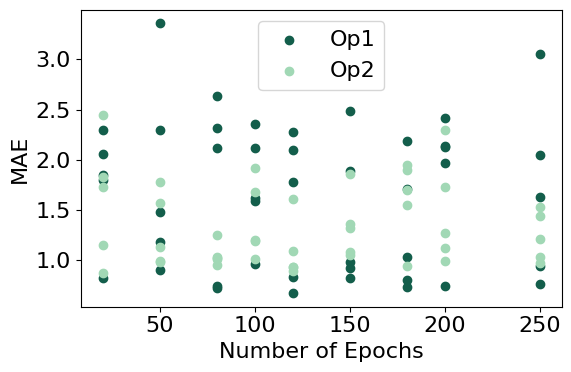

In [24]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(op1_lstm_results[:, 0], op1_lstm_results[:, 1], color=sinr_colors[0], label='Op1')
plt.scatter(op2_lstm_results[:, 0], op2_lstm_results[:, 1], color=sinr_colors[2], label='Op2')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Number of Epochs')
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/overview/n_epochs.pdf')